## Лабораторная работа 1

#### Явная и неявная ***конечно-разностные схемы***, схема Кранка-Николсона. Решение начально краевых задач для уравнений **параболического** типа.

вариант 4

dU / dt = a * d2U / dx2 ; a > 0

U_x(0,t) = exp(-at)

U_x(pi,t) = -exp(-at)

U(x,0) = sin(x)

Аналитическое решение U(x,t) = exp(-at) * sin(x)

In [24]:
from math import pi, sin, exp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Метод прогонки

In [25]:
def solve(m, b):
    y = [None] * len(m)
    alpha = [None] * len(m)
    beta = [None] * len(m)
    for i in range(len(m)):
        if i == 0:
            y[i] = m[i][0]
            alpha[i] = -1 * m[i][1] / y[i]
            beta[i] = b[i] / y[i]
        elif i == len(m) - 1:
            y[i] = m[i][1] + m[i][0] * alpha[i-1]
            beta[i] = (b[i] - m[i][0] * beta[i-1]) / y[i]
        else:
            y[i] = m[i][1] + m[i][0] * alpha[i-1]
            alpha[i] = -1 * m[i][2] / y[i]
            beta[i] = (b[i] - m[i][0] * beta[i-1]) / y[i]
    x = [0] * len(m)
    for i in range(len(m)):
        if i == 0:
            x[len(m)-i-1] = beta[len(m)-i-1]
        else:
            x[len(m)-i-1] = alpha[len(m)-i-1] * x[len(m)-i] + beta[len(m)-i-1]
    return x

### Метод Кранка – Николсона

In [326]:
class CrankNicolson:
    def __init__(self, t_max = 1, t_step = 0.1, x_max = pi, x_step = 0.3, x=10, t=7, a=2):
        self.x_diap = np.linspace(0, x_max, endpoint=True, num=x)
        self.t_diap = np.linspace(0, t_max, endpoint=True, num=t)
        self.x = x
        self.t = t
        self.a = a # данный гиперпараметр можно менять (коэф теплопроводности)
        self.q = ((t_max - 0) / t) / ((x_max - 0) / x)**2 # dt / dx^2
        self.dx = (x_max - 0) / x
        # считаем начальную матрицу первую строчку заполняем начальными условиями остальное None
        self.U = [[sin(self.x_diap[i]) for i in range(self.x)]] + [[None for i in range(self.x)] for j in range(self.t-1)]
    def d(self): # показывает матрицу U
        df = pd.DataFrame(np.array(self.U), columns=self.x_diap, index=self.t_diap)
        print(df, df.shape)
    def display(self): # показывает получившийся + правильный графики решения
        fig, axs = plt.subplots(2,figsize=(12,10))
        fig.suptitle('Метод Кранка – Николсона')
        for i, row in enumerate(self.U):
            axs[0].plot(row, label="t={:.3f}".format(self.t_diap[i]))
        for t in self.t_diap:
            axs[1].plot([exp(-self.a * t) * sin(x) for x in self.x_diap])
        fig.legend()
    def fit(self): # из основной функции выражаем след по времени переменные через текущие известные
        # составляем трехдиагональную матрицу решаем получаем новые значения температур, вписываем их в матрицу
        for i in range(1, self.t):
            M = [[1,0]] + [[-0.5 * self.q * self.a, 1 + self.q * self.a, -0.5 * self.q * self.a] for i in range(1, self.x - 1)] + [[0,1]]
            # попытка выразить гранич условия через производные но получается что то ужасное
            lp = self.U[i-1][0] + 0.5 * self.a * (-exp(-self.a * self.t_diap[i-1]) * self.dx + self.U[i-1][1] - self.U[i-1][0])
            rp = self.U[i-1][len(self.x_diap)-1] + 0.5 * self.a * (self.U[i-1][len(self.x_diap)-1-1] - self.U[i-1][len(self.x_diap)-1] + -exp(-self.a * self.t_diap[i-1]) * self.dx)
            # поэтому на границах ставим нулевую температуру
            B = [0] + \
            [(self.U[i-1][j] + 0.5 * self.a * (self.U[i-1][j-1] - 2 * self.U[i-1][j] + self.U[i-1][j+1])) for j in range(1, self.x - 1)] \
            + [0]
            for idx,item in enumerate(solve(M,B)):
                self.U[i][idx] = item
    def error(self, steps):
        plt.figure(figsize=(8, 6))
        plt.suptitle('Ошибка в зависимости от шага')
        errA = []
        for i in steps[::-1]:
            d = CrankNicolson(x=i)
            real = [exp(-self.a * self.t_diap[::-1][0]) * sin(x) for x in d.x_diap]
            d.fit()
            errA.append(sum([abs(real[j] - d.U[::-1][0][j])**2 for j in range(len(real))])**0.5)
        plt.plot(steps,errA)

          0.000000  0.349066  0.698132  1.047198  1.396263  1.745329  \
0.000000       0.0  0.342020  0.642788  0.866025  0.984808  0.984808   
0.166667       0.0  0.256063  0.481241  0.648375  0.737304  0.737304   
0.333333       0.0  0.191709  0.360295  0.485424  0.552004  0.552004   
0.500000       0.0  0.143528  0.269745  0.363427  0.413273  0.413273   
0.666667       0.0  0.107457  0.201952  0.272090  0.309409  0.309409   
0.833333       0.0  0.080450  0.151197  0.203708  0.231648  0.231648   
1.000000       0.0  0.060232  0.113198  0.152512  0.173430  0.173430   

          2.094395  2.443461  2.792527      3.141593  
0.000000  0.866025  0.642788  0.342020  1.224647e-16  
0.166667  0.648375  0.481241  0.256063  0.000000e+00  
0.333333  0.485424  0.360295  0.191709  0.000000e+00  
0.500000  0.363427  0.269745  0.143528  0.000000e+00  
0.666667  0.272090  0.201952  0.107457  0.000000e+00  
0.833333  0.203708  0.151197  0.080450  0.000000e+00  
1.000000  0.152512  0.113198  0.060232

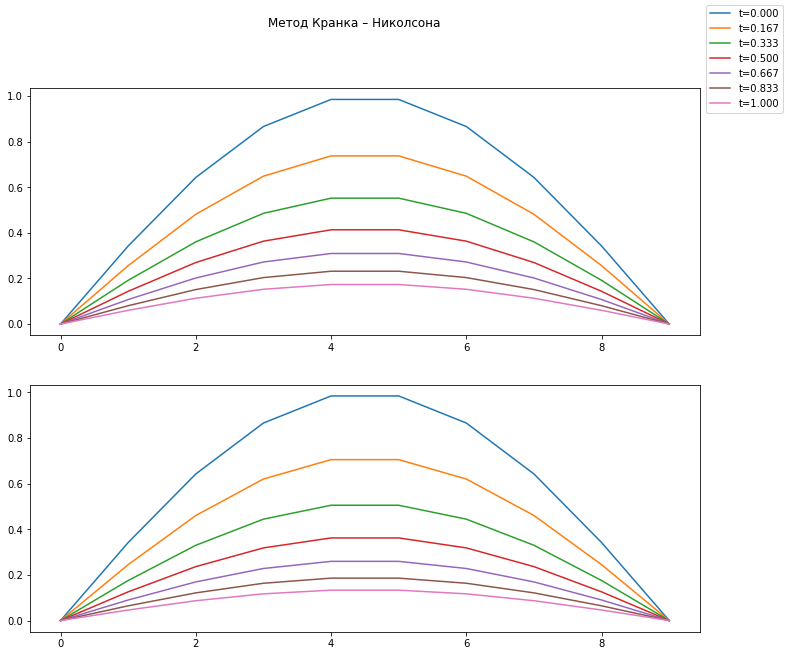

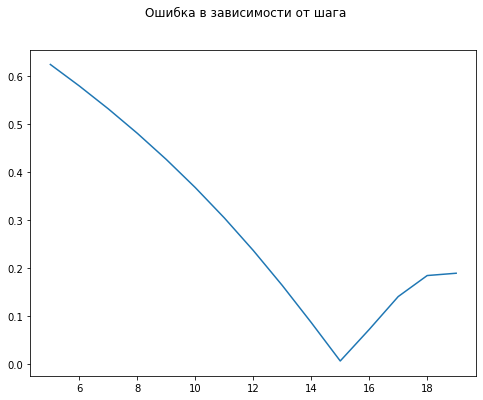

In [328]:
data = CrankNicolson()
data.fit()
data.d()
data.display()
data.error(np.arange(5,20))